In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import graphviz
import itertools

# Process dataset into readable format

The Fashion MNIST dataset files are stored in compressed gzip format (.gz files). To make the data usable, we need to unzip these files and load the binary image and label data into numpy arrays. This allows us to process and analyze the dataset for machine learning tasks.

In [2]:
train_images_path = 'da/train-images-idx3-ubyte.gz'
train_labels_path = 'da/train-labels-idx1-ubyte.gz'
test_images_path = 'da/t10k-images-idx3-ubyte.gz'
test_labels_path = 'da/t10k-labels-idx1-ubyte.gz'

In [3]:
def load_images(filepath): 
    with gzip.open(filepath, 'rb') as f:
        # Read the image data
        images = np.frombuffer(f.read(), np.uint8, offset=16)
        images = images.reshape((-1, 28, 28))
    return images

def load_labels(filepath):
    with gzip.open(filepath, 'rb') as f:
        # Read the label data
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels

In [4]:
train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
test_images = load_images(test_images_path)
test_labels = load_labels(test_labels_path)


In [5]:
print("Training set images shape:", train_images.shape)
print("Training set labels shape:", train_labels.shape)
print("Test set images shape:", test_images.shape)
print("Test set labels shape:", test_labels.shape)

Training set images shape: (60000, 28, 28)
Training set labels shape: (60000,)
Test set images shape: (10000, 28, 28)
Test set labels shape: (10000,)


## 2.1 Preparing the Dataset

In this task, we established the data foundation for our experiments by preparing the training, validation, and test datasets.

We partitioned the original training data into two distinct subsets using the `train_test_split` function. The process adhered to the following specifications:

* **Data Split:** The original training data was split into **80% for model training** (`feature_train`, `label_train`) and **20% for validation** (`feature_val`, `label_val`).
* **Shuffling:** The data was **shuffled** (`shuffle=True`) prior to splitting to ensure that the order of samples does not introduce bias.
* **Test Set:** The provided test set (`feature_test`, `label_test`) was left unmodified and reserved exclusively for the final experimental evaluation.

### Distribution Visualization
To verify the quality of the split, we visualized the number of samples per class across the Original, Training, Validation, and Test datasets.



In [6]:
feature_train, feature_val, label_train, label_val = train_test_split(
    train_images, 
    train_labels, 
    test_size=0.20, 
    shuffle=True,
    random_state=128
)

print("Training set images shape:", feature_train.shape)
print("Training set labels shape:", label_train.shape)
print("Validation set images shape:", feature_val.shape)
print("Validation set labels shape:", label_val.shape)

Training set images shape: (48000, 28, 28)
Training set labels shape: (48000,)
Validation set images shape: (12000, 28, 28)
Validation set labels shape: (12000,)


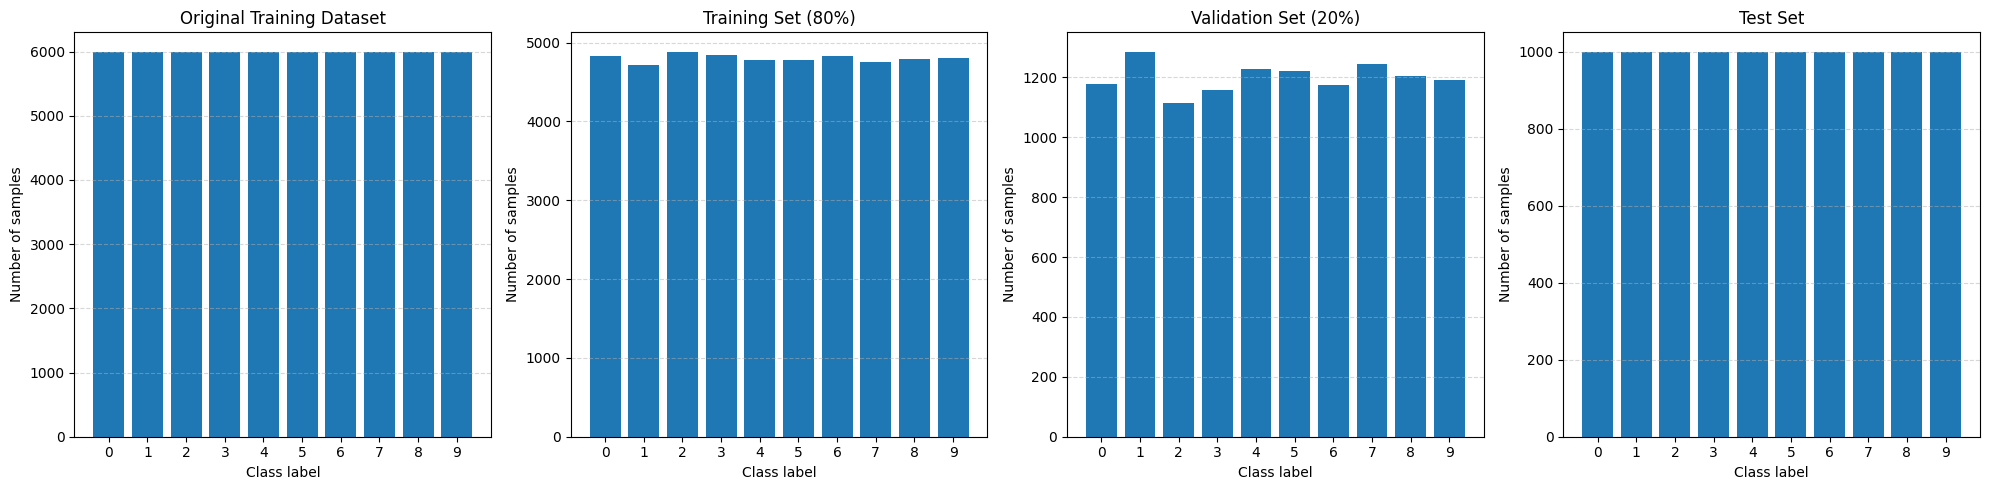

In [7]:
datasets_to_plot = [
    ("Original Training Dataset", train_labels),
    ("Training Set (80%)", label_train),
    ("Validation Set (20%)", label_val),
    ("Test Set", test_labels)
]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, (title, data) in zip(axes, datasets_to_plot):

    unique, counts = np.unique(data, return_counts=True)
    
    ax.bar(unique, counts, align='center')
    
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Class label', fontsize=10)
    ax.set_ylabel('Number of samples', fontsize=10)
    ax.set_xticks(unique) 
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 2.2 Building the Decision Tree Classifier

In this section, we trained an initial decision tree model to understand the hierarchical structure of the data.

We utilized the `sklearn.tree.DecisionTreeClassifier` with the following configuration:
* **Criterion:** `entropy` (Information Gain) was used to measure the quality of the splits.
* **Data Preparation:** The 28x28 images were flattened into 784-dimensional vectors to suit the classifier's input requirements.
* **Visualization:** To interpret the model's decision-making process, we limited the tree depth (`max_depth=3`) and visualized the resulting structure using Graphviz.

In [8]:
n_samples = feature_train.shape[0]
n_features = feature_train.shape[1] * feature_train.shape[2] 
feature_train_flat = feature_train.reshape(n_samples, n_features)

In [9]:
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

print("Training Decision Tree...")
dt_model.fit(feature_train_flat, label_train)
print("Training Complete.")

Training Decision Tree...
Training Complete.


In [10]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

dot_data = export_graphviz(
    dt_model,
    out_file=None,
    feature_names=[f"pixel_{i}" for i in range(n_features)],
    class_names=class_names,
    filled=True,
    rounded=True,
    special_characters=True
)

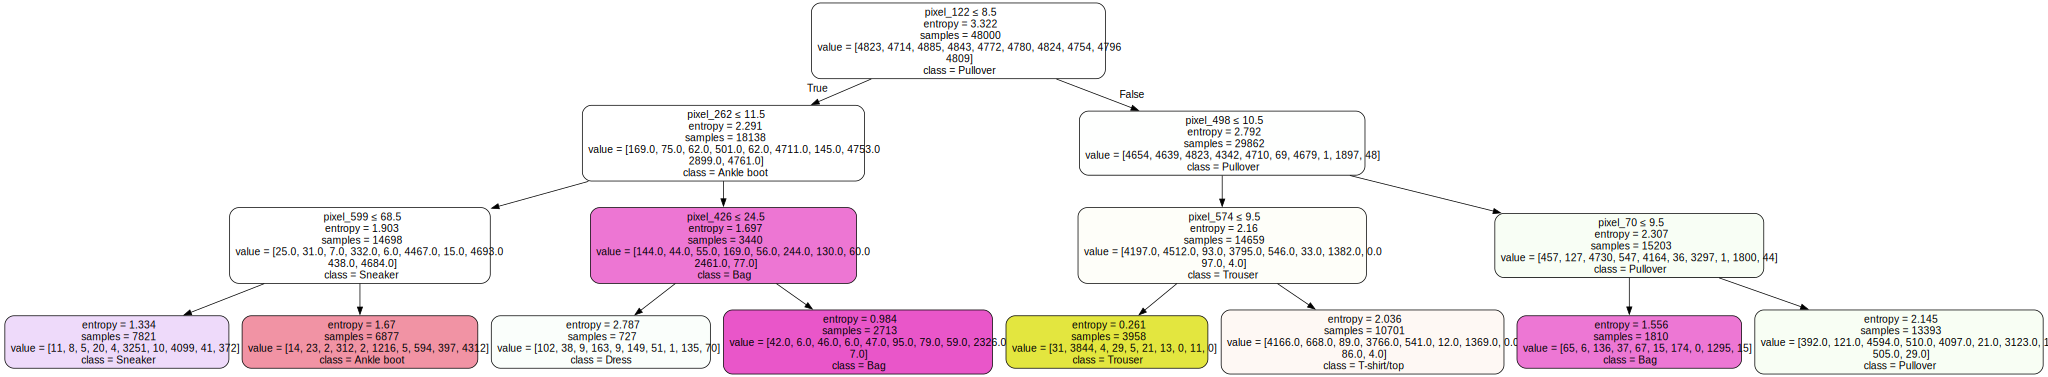

In [11]:
graph = graphviz.Source(dot_data)
graph.render("fashion_mnist_tree") # Saves a PDF/file named 'fashion_mnist_tree'

graph

## 2.3 Hyperparameter Tuning for Decision Tree Classifier

In this task, we performed hyperparameter tuning to optimize the performance of the Decision Tree classifier. The goal was to find the configuration that generalizes best to unseen data by maximizing accuracy on the validation set.

We conducted a systematic grid search over the following key hyperparameters:

* **`max_depth`**: Controls the maximum depth of the tree. We tested values of `[10, 20, 30, None]` to find the balance between underfitting (too shallow) and overfitting (too deep).
* **`min_samples_split`**: The minimum number of samples required to split an internal node. We tested values of `[2, 10, 20]`. Higher values prevent the tree from learning overly specific rules based on very few samples.
* **`min_samples_leaf`**: The minimum number of samples required to be at a leaf node. We tested values of `[1, 5, 10]` to ensure that leaf predictions are based on a robust amount of data.

For each combination, a `DecisionTreeClassifier` (using criterion='entropy') was trained on the training set and evaluated on the validation set.

In [12]:
n_samples_val = feature_val.shape[0]
feature_val_flat = feature_val.reshape(n_samples_val, -1)

In [13]:
param_grid = {
    'max_depth': [10, 20, 30, None],          
    'min_samples_split': [2, 10, 20],         
    'min_samples_leaf': [1, 5, 10]           
}

keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Testing {len(combinations)} different configurations...")

Testing 36 different configurations...


In [14]:
best_accuracy = 0.0
best_params = {}
best_model = None

for i, params in enumerate(combinations):
    dt_model = DecisionTreeClassifier(
        criterion='entropy',
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=42
    )
    
    dt_model.fit(feature_train_flat, label_train)
    
    predictions = dt_model.predict(feature_val_flat)
    accuracy = accuracy_score(label_val, predictions)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = dt_model
        
    # Optional: Print progress every 6 iterations - This might take a while (about 15 - 19 minutes on my laptop)
    if (i + 1) % 6 == 0:
        print(f"Iter {i+1}/{len(combinations)} - Current Acc: {accuracy:.4f} | Best Acc: {best_accuracy:.4f}")

Iter 6/36 - Current Acc: 0.8137 | Best Acc: 0.8142
Iter 12/36 - Current Acc: 0.8088 | Best Acc: 0.8145
Iter 18/36 - Current Acc: 0.8088 | Best Acc: 0.8145
Iter 24/36 - Current Acc: 0.8079 | Best Acc: 0.8145
Iter 30/36 - Current Acc: 0.8079 | Best Acc: 0.8145
Iter 36/36 - Current Acc: 0.8079 | Best Acc: 0.8145


In [15]:
print("-" * 30)
print(f"Best Validation Accuracy: {best_accuracy:.4f}")
print(f"Best Hyperparameters: {best_params}")
print("-" * 30)

------------------------------
Best Validation Accuracy: 0.8145
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 1}
------------------------------


## 2.4 Building the Neural Network Classifier

In this section, we construct and train a Multi-Layer Perceptron (MLP) classifier using the `sklearn.neural_network.MLPClassifier` module. The goal is to establish a robust baseline neural network model to compare against the decision tree classifier developed in the previous section.

### Model Architecture and Hyperparameters

We fit the model to the flattened training set (`feature_train_flat`) and evaluate its performance on the validation set (`feature_val_flat`). As per the requirements, the network includes at least one hidden layer and a non-linear activation function.

We explicitly selected the following architecture and hyperparameters for this model:

* **Number of Hidden Layers:** 1
* **Neurons per Layer:** 128
* **Activation Function:** `relu` (Rectified Linear Unit) - chosen to introduce non-linearity.
* **Optimization Algorithm:** `adam` - a stochastic gradient-based optimizer suitable for large datasets.
* **Learning Rate Strategy:** `constant` (Default setting for the Adam solver).
* **Maximum Iterations:** 300 - increased from the default (200) to ensure the model converges fully during training.

All other parameters were maintained at their default `sklearn` settings. The trained model is evaluated below using the validation accuracy metric and will be saved for the final comparison on the test set.

In [16]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128,), 
    activation='relu', 
    solver='adam', 
    max_iter=300, 
    random_state=42
)

In [17]:
mlp_model.fit(feature_train_flat, label_train)

MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42)

In [18]:
predictions_mlp = mlp_model.predict(feature_val_flat)
accuracy_mlp = accuracy_score(label_val, predictions_mlp)

print("-" * 30)
print(f"Neural Network Validation Accuracy: {accuracy_mlp:.4f}")
print("-" * 30)

------------------------------
Neural Network Validation Accuracy: 0.8574
------------------------------


## 2.5 Performance Evaluation and Comparison

In this section, we evaluate the performance of the tuned **Decision Tree (DT)** and the **Neural Network (NN)** on the held-out test set ($N=10,000$ samples). We utilize the classification report and confusion matrix to analyze the results.

### 1. Interpretation of Metrics

To assess the models, we interpret two key evaluation tools:

* **Classification Report:**
    * **Precision:** Indicates the accuracy of positive predictions (e.g., of all images predicted as "Sneaker", how many were actually Sneakers?). High precision means fewer false positives.
    * **Recall:** Measures the model's ability to capture all positive instances (e.g., of all actual "Sneakers", how many did we find?). High recall means fewer false negatives.
    * **F1-Score:** The harmonic mean of precision and recall. This is a critical metric for this dataset as it balances both concerns, providing a single score that highlights if a model is biased toward one metric.
    * **Accuracy:** The total percentage of correctly classified images across all 10 categories.

* **Confusion Matrix:**
    * This visualizes the exact breakdown of predictions. The **diagonal** elements represent correct classifications. Values **off the diagonal** represent errors, showing exactly which classes are being confused with one another (e.g., confusing a "Shirt" with a "T-shirt").

### 2. Model Comparison and Insights

Based on the evaluation results, we compare the two models:

* **Overall Accuracy:**
    The **Neural Network** achieved a significantly higher overall accuracy compared to the **Decision Tree** about 6% more. This performance gap indicates that the neural network's architecture is better suited for the high-dimensional, raw pixel data of the Fashion-MNIST dataset.

* **Class-Specific Performance:**
    * **Decision Tree:** The classification report shows high variance in F1-scores. While it performs well on distinct shapes like *Trousers* (Class 1), it struggles significantly with visually similar items like *Pullover* vs. *Coat*.
    * **Neural Network:** Demonstrated higher and more consistent F1-scores across almost all categories. The use of the ReLU activation function allows the network to learn non-linear features (like textures and curves) that a simple decision tree cannot capture.

* **Confusion Matrix Analysis:**
    * The **Decision Tree's** matrix displays significant "noise" off the diagonal. It frequently misclassifies *Pullovers* (Class 2), *Coats* (Class 4), and *Shirts* (Class 6) as each other. This confirms that the rigid, axis-aligned splits of the tree are insufficient for distinguishing subtle fashion details.
    * The **Neural Network's** matrix is much "cleaner," with predictions tightly concentrated on the diagonal. However, it still exhibits some confusion between *T-shirt* and *Shirt*, which is a known challenge in this dataset due to their visual overlap.

In [19]:
n_test_samples = test_images.shape[0]
feature_test_flat = test_images.reshape(n_test_samples, -1)

In [20]:
y_pred_dt = best_model.predict(feature_test_flat)
y_pred_mlp = mlp_model.predict(feature_test_flat)

In [21]:
print("="*30)
print("DECISION TREE REPORT")
print("="*30)
# Use 'test_labels' here - this is the ground truth for the test set
print(classification_report(test_labels, y_pred_dt))

DECISION TREE REPORT
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1000
           1       0.97      0.93      0.95      1000
           2       0.71      0.63      0.67      1000
           3       0.82      0.83      0.83      1000
           4       0.63      0.78      0.70      1000
           5       0.93      0.86      0.89      1000
           6       0.59      0.49      0.53      1000
           7       0.85      0.91      0.88      1000
           8       0.93      0.92      0.92      1000
           9       0.91      0.92      0.91      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000



In [22]:
print("\n" + "="*30)
print("NEURAL NETWORK REPORT")
print("="*30)
print(classification_report(test_labels, y_pred_mlp))


NEURAL NETWORK REPORT
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1000
           1       0.96      0.97      0.96      1000
           2       0.71      0.79      0.75      1000
           3       0.81      0.89      0.85      1000
           4       0.79      0.68      0.73      1000
           5       0.96      0.94      0.95      1000
           6       0.66      0.56      0.61      1000
           7       0.94      0.90      0.92      1000
           8       0.94      0.95      0.94      1000
           9       0.91      0.96      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



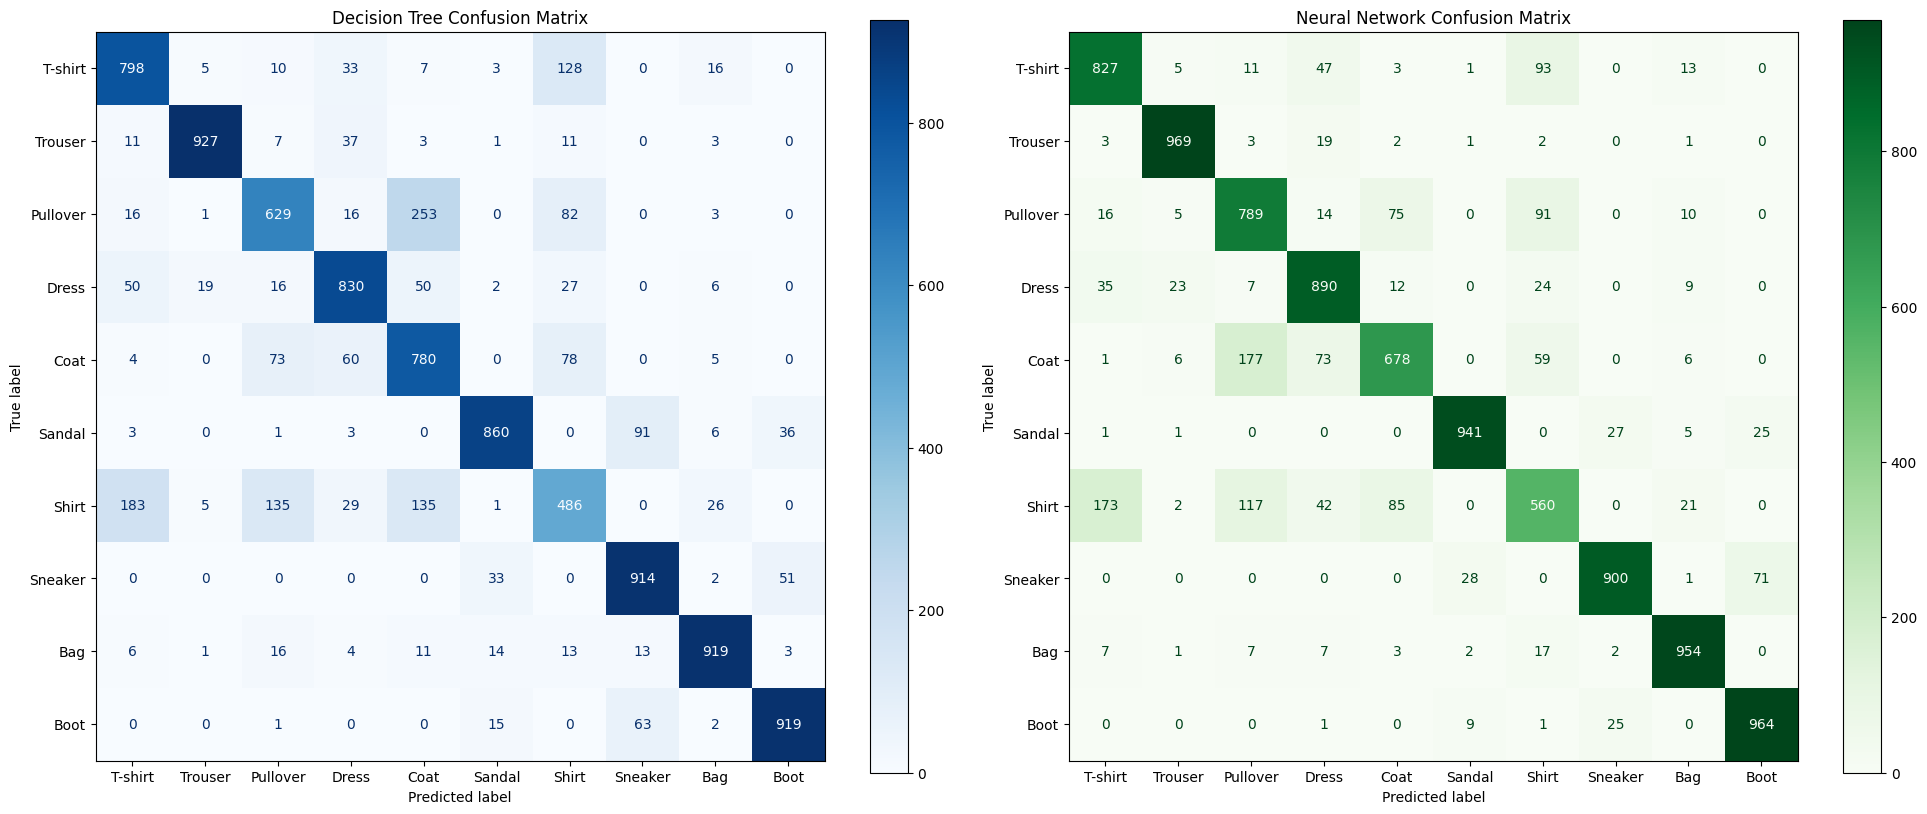

In [23]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
cm_dt = confusion_matrix(test_labels, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=class_names)
disp_dt.plot(ax=ax[0], cmap='Blues', values_format='d')
ax[0].set_title("Decision Tree Confusion Matrix")

cm_nn = confusion_matrix(test_labels, y_pred_mlp)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=class_names)
disp_nn.plot(ax=ax[1], cmap='Greens', values_format='d')
ax[1].set_title("Neural Network Confusion Matrix")

plt.tight_layout()
plt.show()